# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

**Method to compare the density of two distributions** : 

The **Kullback-Leibler divergence** from $p_{\theta}$ to $p_D$ is defined  as follows :

> $$D_{KL}(p_D || p_{\theta}) = E_{x \sim p_D} \left[ \log \frac{p_D(x)}{p_{\theta}(x)} \right] = - E_{x \sim p_D} \left[ \log p_{\theta}(x) \right] - H(p_D) $$

**Jensen-Shannon Divergence** is a symmetrized and smoothed version of the Kullback–Leibler divergence.It is defined as:
>$JSD(p_D \| p_\theta) = \cfrac{1}{2} \Big(D_{KL} (p_D \| p_M) + D_{KL} (p_\theta \| p_M) \Big)$ with $p_M = \cfrac{1}{2} \Big(p_D + p_\theta \Big)$

** Optimal transport distance ** This is a real distance between probability distributions this distance is obtained by solving the optimization problem : $$ {\displaystyle W_{p}(\mu ,\nu ):=\left(\inf _{\gamma \in \Gamma (\mu ,\nu )}\int _{M\times M}d(x,y)^{p}\,\mathrm {d} \gamma (x,y)\right)^{1/p},}$$ 

source : https://www.stat.cmu.edu/~cshalizi/754/2006/notes/lecture-28.pdf
https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence






Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

As we have access only to samples from the two **distributions** that we want to compare we cannot compute the KL or JSD divergence explicitly. 


In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

>N represents the variability within the generated data and thus our latent space.

Our final goal is to be able to generate good images from inputs coming from the whole latent space.

With a small value of Nn the GAN will have difficulty to produce well variated data and will probably generate data perfectly close to what the discriminator. Thus it's makes it easier for the generator to simply mimic the training data and thus overfit.

With a high value of N, after $p$ training cycles the model will have only visited a small proportion of the latent space (curse of dimensionality).

The model cannot learn good representations of the data as it will have really low chances to visit the same neighbourhood in the latent space.

For example from cycle 1-10 we visit a certain neighbourhood $N_1$of the latent space and with gradient descent we now generate good images from this neighbourhood.

After 10 other cycles we now generate good representations for another distinct  neighbourhood $N_2$ and this does not guarantee the quality of the images generated using $N_1$

As a conclusion, the model would probably not be stable and then slow convergence.
Also, large dimension N would lead to a model with high # of parameters and then computaion will be costly.

> Thus N is a very important parameter that needs tuning.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**


**the JSD is upper bounded by** :

$$\begin{align} JSD(p_\theta || p_D) &\leq \log (2)\end{align}$$

At the beginning of the training of the generator the distribution of the generated data $p_\theta$ is quite far from the real data distribution $p_d$.

Therefore, it's JSD is almost maximal around log(2). And thus the discriminator loss $\mathcal{L}_D $~ 0.  And thus the discriminator is perfectly distinguishing between the generated and real samples.

Therefore the generator loss $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $ ~ 0 will be small resulting in vanishing gradients and a slow training of the discriminator.



Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

The risk is that the generator **collapse**, Indeed :

if your discriminator is too good, then generator training can fail due to vanishing gradients. In effect, an optimal discriminator doesn't provide enough information for the generator to make progress.

If the discriminator is too bad, the generator will be  receiving an almlost random feedback. The training of the generator will not be consistent as from one round to another the gradients we will pointing to random directions.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [5]:
import torch
import math
from sklearn import datasets
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

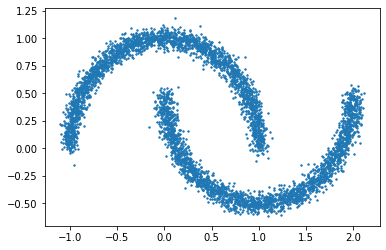

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    
    def __init__(self, depth, width):

        super().__init__()
        
        self.depth = depth
        
        self.fc_init = nn.Linear(PRIOR_N, width)
        
        if self.depth>2:
            self.hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.hidden.append(nn.Linear(width, width))
            
        self.fc_end = nn.Linear(width, 2)
        
    def __call__(self, z):
        
        h = F.relu(self.fc_init(z))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.hidden[d](h))
            
        return self.fc_end(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, depth, width):

        super().__init__()
        
        self.depth = depth
        
        self.fc_init = nn.Linear(2, width)
        
        if self.depth>2:
            self.hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.hidden.append(nn.Linear(width, width))
            
        self.fc_end = nn.Linear(width, 1)
        
    def __call__(self, z):
        
        h = F.relu(self.fc_init(z))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.hidden[d](h))

        return self.fc_end(h)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [ ]:

def Train_GAN(N_ITER = 20001,  BATCHLEN = 128 , TRAIN_RATIO=1, depth_generator=2, width_generator=2, depth_descriminator=2, width_discriminator=2, Verbose=False, plot = True) :
      
       

        generator = Generator(depth_generator, width_generator)
        optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
        discriminator = Discriminator(depth_descriminator, width_discriminator)
        optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
        discrimi_loss = np.zeros(N_ITER)
        generator_loss = np.zeros(N_ITER)
        for i in tqdm(range(N_ITER)):
            # train the discriminator
            for _ in range(TRAIN_RATIO):
                discriminator.zero_grad()
                real_batch = generate_batch(BATCHLEN)
                fake_batch = generator.generate(BATCHLEN)
                output_real = discriminator(real_batch)
                output_fake = discriminator(fake_batch)
                disc_loss = F.softplus(-output_real) + F.softplus(output_fake)
                disc_loss = disc_loss.mean() 
                disc_loss.backward()
                discrimi_loss[i] += disc_loss.item()
                optim_disc.step()
            discrimi_loss[i] /= TRAIN_RATIO
            # train the generator
            generator.zero_grad()
            fake_batch = generator.generate(BATCHLEN)
            output_fake = discriminator(fake_batch)
        
            gen_loss = F.softplus(-output_fake) 
            gen_loss = gen_loss.mean()
            gen_loss.backward()
            optim_gen.step()
            generator_loss[i]=gen_loss.item()
            if Verbose : 
              if i%1000 == 0:
                  print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
                  # plot the result
                  real_batch = generate_batch(1024)
                  fake_batch = generator.generate(1024).detach()
                  plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
                  plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
                  plt.legend()
                  plt.show()
        if plt :  
          real_batch = generate_batch(1024)
          fake_batch = generator.generate(1024).detach()
          plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
          plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
          plt.legend()
          plt.show()
        return generator_loss, discrimi_loss

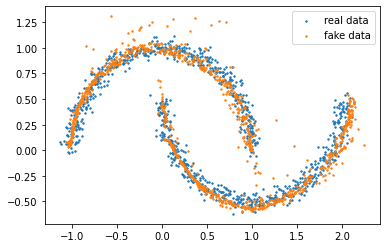

In [ ]:
gen_loss, disc_loss = Train_GAN(N_ITER = 20001, TRAIN_RATIO=1, depth_generator=3, width_generator=50, depth_descriminator=3, width_discriminator=50, Verbose=False, plot = True)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> (Write your answer here)

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

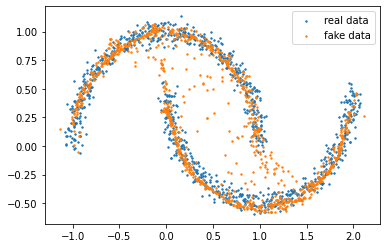

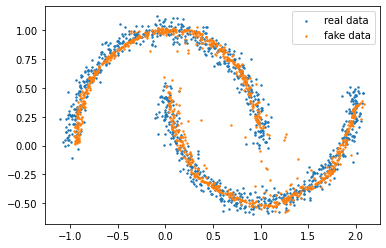

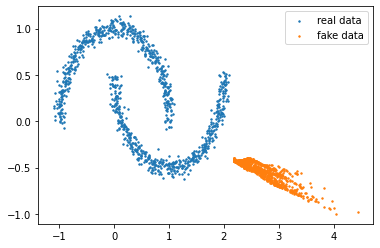

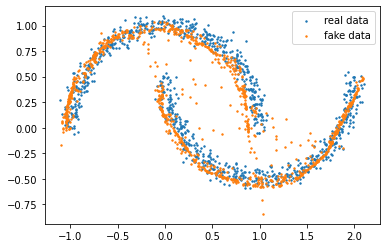

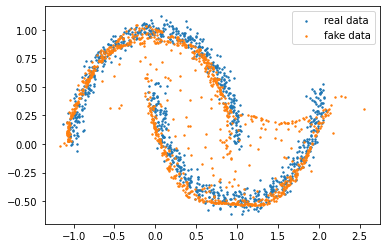

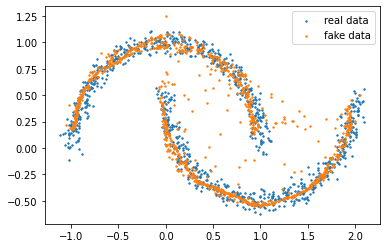

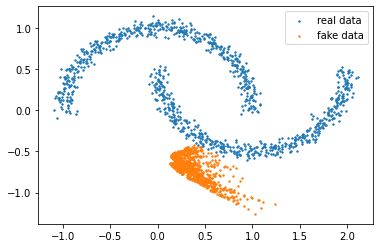

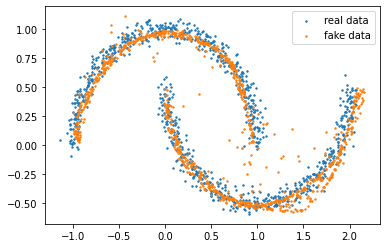

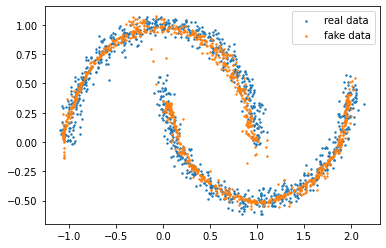

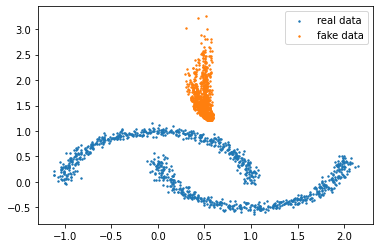

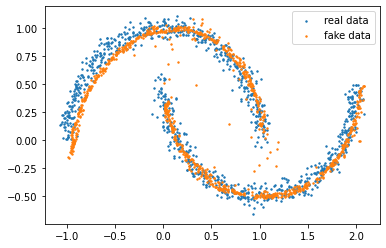

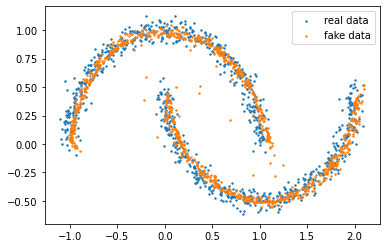

In [ ]:

depths = [2,3,4]
widths = [20,50,200]
TRAIN_RATIOs = [1,2,10]
N_ITER = 5000

depths_gen = []
for d in depths:
    gen_loss, dis_loss = Train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_generator=d, width_generator=50, depth_descriminator=3, width_discriminator=50, Verbose=False , plot = True)
    depths_gen.append((gen_loss, dis_loss,d))

widths_gen = []
for w in widths:
    gen_loss, dis_loss = Train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_generator=3, width_generator=w, depth_descriminator=3, width_discriminator=50, Verbose=False , plot = True)
    widths_gen.append((gen_loss, dis_loss,w))


depths_desc = []
for d in depths:
    gen_loss, dis_loss = Train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_generator=3, width_generator=50, depth_descriminator=d, width_discriminator=50, Verbose=False , plot = True)
    depths_desc.append((gen_loss, dis_loss,d))

widths_desc = []
for w in widths:
    gen_loss, dis_loss = Train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_generator=3, width_generator=50, depth_descriminator=3, width_discriminator=w, Verbose=False , plot = True)
    widths_desc.append((gen_loss, dis_loss,w))




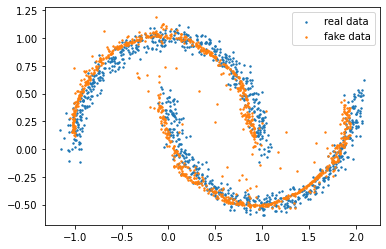

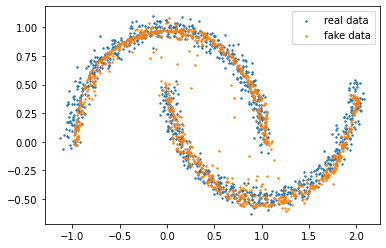

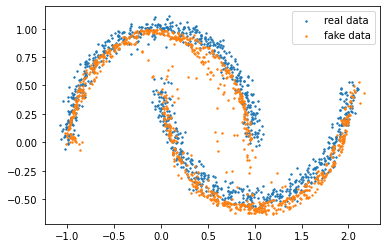

In [ ]:
TRAIN_RATIOs = [1,10,20]
N_ITER = 5000
TRAIN_RATIOs_loss = []
for t in TRAIN_RATIOs:
    gen_loss, dis_loss = Train_GAN(N_ITER=N_ITER, TRAIN_RATIO=t, depth_generator=3, width_generator=50, depth_descriminator=3, width_discriminator=50, Verbose=False , plot = True)
    TRAIN_RATIOs_loss.append((gen_loss, dis_loss,t))


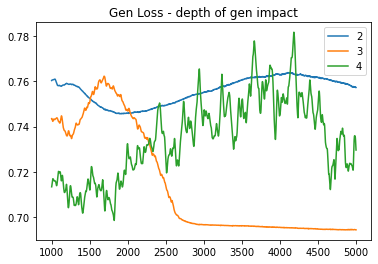

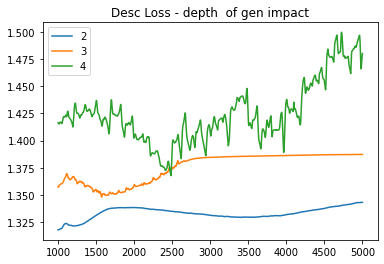

In [ ]:
#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(depths_gen[0][0]).rolling(window=1000).mean(),label=depths_gen[0][2])
plt.plot(pd.Series(depths_gen[1][0]).rolling(window=1000).mean(),label=depths_gen[1][2])
plt.plot(pd.Series(depths_gen[2][0]).rolling(window=1000).mean(),label=depths_gen[2][2])
plt.legend()
plt.title('Gen Loss - depth of gen impact')
plt.show()

#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(depths_gen[0][1]).rolling(window=1000).mean(),label=depths_gen[0][2])
plt.plot(pd.Series(depths_gen[1][1]).rolling(window=1000).mean(),label=depths_gen[1][2])
plt.plot(pd.Series(depths_gen[2][1]).rolling(window=1000).mean(),label=depths_gen[2][2])
plt.legend()
plt.title('Desc Loss - depth  of gen impact')
plt.show()

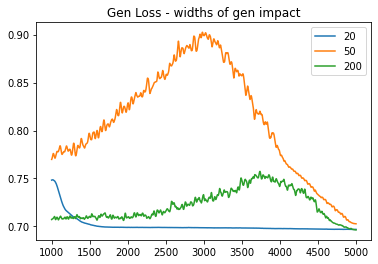

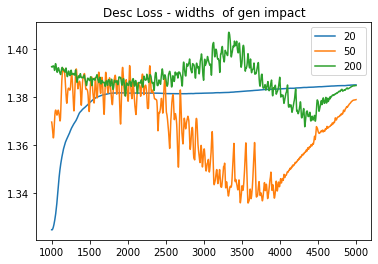

In [ ]:
#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(widths_gen[0][0]).rolling(window=1000).mean(),label=widths_gen[0][2])
plt.plot(pd.Series(widths_gen[1][0]).rolling(window=1000).mean(),label=widths_gen[1][2])
plt.plot(pd.Series(widths_gen[2][0]).rolling(window=1000).mean(),label=widths_gen[2][2])
plt.legend()
plt.title('Gen Loss - widths of gen impact')
plt.show()

#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(widths_gen[0][1]).rolling(window=1000).mean(),label=widths_gen[0][2])
plt.plot(pd.Series(widths_gen[1][1]).rolling(window=1000).mean(),label=widths_gen[1][2])
plt.plot(pd.Series(widths_gen[2][1]).rolling(window=1000).mean(),label=widths_gen[2][2])
plt.legend()
plt.title('Desc Loss - widths  of gen impact')
plt.show()

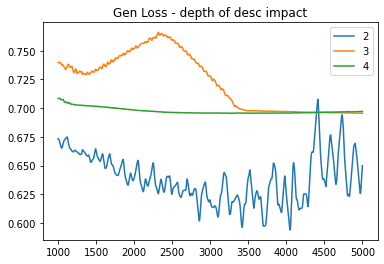

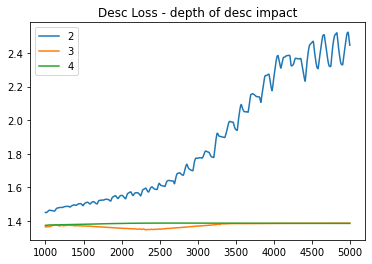

In [ ]:
#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(depths_desc[0][0]).rolling(window=1000).mean(),label=depths_desc[0][2])
plt.plot(pd.Series(depths_desc[1][0]).rolling(window=1000).mean(),label=depths_desc[1][2])
plt.plot(pd.Series(depths_desc[2][0]).rolling(window=1000).mean(),label=depths_desc[2][2])
plt.legend()
plt.title('Gen Loss - depth of desc impact')
plt.show()

#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(depths_desc[0][1]).rolling(window=1000).mean(),label=depths_desc[0][2])
plt.plot(pd.Series(depths_desc[1][1]).rolling(window=1000).mean(),label=depths_desc[1][2])
plt.plot(pd.Series(depths_desc[2][1]).rolling(window=1000).mean(),label=depths_desc[2][2])
plt.legend()
plt.title('Desc Loss - depth of desc impact')
plt.show()

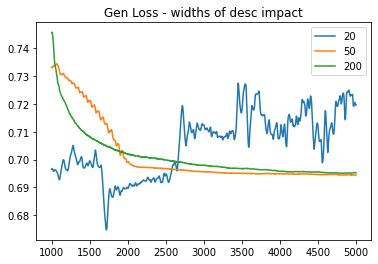

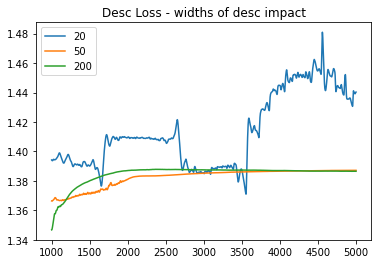

In [ ]:
#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(widths_desc[0][0]).rolling(window=1000).mean(),label=widths_desc[0][2])
plt.plot(pd.Series(widths_desc[1][0]).rolling(window=1000).mean(),label=widths_desc[1][2])
plt.plot(pd.Series(widths_desc[2][0]).rolling(window=1000).mean(),label=widths_desc[2][2])
plt.legend()
plt.title('Gen Loss - widths of desc impact')
plt.show()

#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(widths_desc[0][1]).rolling(window=1000).mean(),label=widths_desc[0][2])
plt.plot(pd.Series(widths_desc[1][1]).rolling(window=1000).mean(),label=widths_desc[1][2])
plt.plot(pd.Series(widths_desc[2][1]).rolling(window=1000).mean(),label=widths_desc[2][2])
plt.legend()
plt.title('Desc Loss - widths of desc impact')
plt.show()

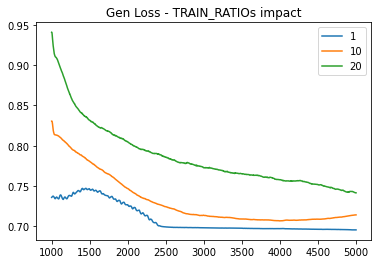

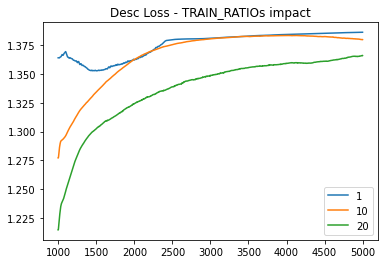

In [ ]:
#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(TRAIN_RATIOs_loss[0][0]).rolling(window=1000).mean(),label=TRAIN_RATIOs_loss[0][2])
plt.plot(pd.Series(TRAIN_RATIOs_loss[1][0]).rolling(window=1000).mean(),label=TRAIN_RATIOs_loss[1][2])
plt.plot(pd.Series(TRAIN_RATIOs_loss[2][0]).rolling(window=1000).mean(),label=TRAIN_RATIOs_loss[2][2])
plt.legend()
plt.title('Gen Loss - TRAIN_RATIOs impact')
plt.show()

#Comparing Gen_loss and desc loss #
plt.plot(pd.Series(TRAIN_RATIOs_loss[0][1]).rolling(window=1000).mean(),label=TRAIN_RATIOs_loss[0][2])
plt.plot(pd.Series(TRAIN_RATIOs_loss[1][1]).rolling(window=1000).mean(),label=TRAIN_RATIOs_loss[1][2])
plt.plot(pd.Series(TRAIN_RATIOs_loss[2][1]).rolling(window=1000).mean(),label=TRAIN_RATIOs_loss[2][2])
plt.legend()
plt.title('Desc Loss - TRAIN_RATIOs impact')
plt.show()

## Commentary :
> - *Generator depth* : If the generator depth is too small, the generator loss increases at the begining of the training while the discriminator loss decreases, it might be seen as a lack of variety of generate data which lead the discriminator to not be fooled. if the generator depth is too large (4), we see that the training is noisy.

> - *Generator width* : The generator width is not too large then the model is noisy and slow to train. with small value the training is fast.

> - *Discriminator depth* : If the discriminator depth is too large, then the discriminator loss take time to converge, it increase fast in the beginning after it reach a maxima, which imply a vaniching gradient of generator. a small value lead to a noisy training, it seems like the power of the discriminator is low to distinguish between sample.

> - *Discriminator width* : the higher the width of Discriminator more likely the generator loss gradient is to vanish and then to slow learning.
if the value is small then the learning is noisy.

> - *TRAIN RATIO* : TRAIN RATIO parameter is large then training is slow, but stable, the discriminator loss increas until reaching a maximum, the generator loss decrease accordingly. the higher TRAIN RATIO parameter more likely the generator loss gradient is to vanish.


For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> $\begin{align} D_{KL}(p_D \| p_\theta) &= E_{x \sim p_D} \left[ \log \frac{p_D(x)}{p_{\theta}(x)} \right] \\ &= E_{x \sim p_D} \left[ \log p_{D}(x) \right] - E_{x \sim p_D} \left[ \log p_{\theta}(x) \right] \\  &= Cte - E_{x \sim p_D} \left[ \log p_{\theta}(x) \right] \end{align}$


> since $E_{x \sim p_D} \left[ \log p_{D}(x) \right]$ is invariant to $\theta$.

> Hence, maximizing $\mathbb{E}_{p_D} \log p_\theta(x)$ is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$> 

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> $D_{KL}(q_\phi(z | x) \| p(z)) = E_{q_\phi(z | x)} \left[ \log \frac{q_\phi(z | x)}{p(z)} \right]$ will be low one when $q_\phi(z | x) \rightarrow  0$ and $p(z)$ near $1$. 

 The regularization term penalizes setting a non zero weight to an area of the latent space which has an almost 0 probability is heavily penalized which is good.
 On the other hand it does does not penalize giving  0 weight's to areas of high probability the latent space.  This is a byproduct of the non symmetric KL divergence.

This can lead to posterior distributions, which will have the same support as the prior but where the mass may be separated into disjoint blocs, contrary to the gaussian prior where the mass is more smoothly partioned on the support.


Maybe using a JSD divergence can solve this problem. 

**GOOD ELBO VALUES DO NOT IMPLY ACCURATE INFERENCE**



A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

probabilty density function of multivariate Normal distribution is given by :

> $$ p(x) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}} \exp \left[-\frac{
\left(x-\mu\right)^{T} \Sigma^{-1}\left(x-\mu\right)}{2}\right]$$

Now, let our two Normal distributions be  $\mathcal{N}(\mu_p; \sigma_p)$ and  $\mathcal{N}(\mu_q; \sigma_q)$ ,both $k$  dimensional.

$D_{KL}(p \| q) =\mathrm{E}_{p}\left[\log p-\log q\right] \\
=\mathrm{E}_{p}\left[\frac{1}{2} \log \left(\frac{|\Sigma_q|}{|\Sigma_p|}\right) -\frac{1}{2}\left(x-\mu_{p}\right)^{T} \Sigma_{p}^{-1}\left(x-\mu_{p}\right)+\frac{1}{2}\left(x-\mu_{q}\right)^{T} \Sigma_{q}^{-1}\left(x-\mu_{q}\right)\right] 
\\
=\frac{1}{2}\mathrm{E}_{p}\left[\log \left(\frac{|\Sigma_q|}{|\Sigma_p|}\right)\right]  -\frac{1}{2}\mathrm{E}_{p}\left[\left(x-\mu_{p}\right)^{T} \Sigma_{p}^{-1}\left(x-\mu_{p}\right)\right] +\frac{1}{2}\mathrm{E}_{p}\left[\left(x-\mu_{q}\right)^{T} \Sigma_{q}^{-1}\left(x-\mu_{q}\right)\right] 
\\
=\frac{1}{2}\log \left(\frac{|\Sigma_q|}{|\Sigma_p|}\right) -\frac{1}{2}\mathrm{E}_{p}\left[\left(x-\mu_{p}\right)^{T} \Sigma_{p}^{-1}\left(x-\mu_{p}\right)\right] +\frac{1}{2}\mathrm{E}_{p}\left[\left(x-\mu_{q}\right)^{T} \Sigma_{q}^{-1}\left(x-\mu_{q}\right)\right] (1)
$

Now, since $\left(x-\mu_{p}\right)^{T} \Sigma_{p}^{-1}\left(x-\mu_{p}\right) $ is in can be written as $ tr\left(x-\mu_{p}\right)^{T} \Sigma_{p}^{-1}\left(x-\mu_{p}\right) $ where $tr$ is trace operator. And hence is equal to 

$ tr(\left(x-\mu_{p}\right)^{T} (x-\mu_{p})\Sigma_{p}^{-1}) $

> Now the second term in (1) is now : 

> $\frac{1}{2}\mathrm{E}_{p}\left[tr(\left(x-\mu_{p}\right)^{T} (x-\mu_{p})\Sigma_{p}^{-1}))\right] = \frac{1}{2}tr(\mathrm{E}_{p}\left[\left(x-\mu_{p}\right)^{T} (x-\mu_{p})\Sigma_{p}^{-1})\right] )\\
= \frac{1}{2}tr(\mathrm{E}_{p}\left[\left(x-\mu_{p}\right)^{T} (x-\mu_{p})\right] \Sigma_{p}^{-1}))\\
$

And since :
> $\mathrm{E}_{p}\left[\left(x-\mu_{p}\right)^{T} (x-\mu_{p})\right] = \Sigma_{p}$

>$\frac{1}{2}\mathrm{E}_{p}\left[tr(\left(x-\mu_{p}\right)^{T} (x-\mu_{p})\Sigma_{p}^{-1}))\right] = \frac{1}{2}tr(\Sigma_{p}\Sigma_{p}^{-1}) \\
= \frac{1}{2}tr(I)\\
= \frac{1}{2}k\\
$

The third term of (1) can be written, 
> $ \mathrm{E}_{p}\left[\left(x-\mu_{q}\right)^{T} \Sigma_{q}^{-1}\left(x-\mu_{q}\right)\right] = \left(\mu_{p}-\mu_{q}\right)^{T} \Sigma_{q}^{-1}\left(\mu_{p}-\mu_{q}\right) + tr(\Sigma_{q}^{-1}\Sigma_{p})$ 
>[1]

[1] : eq 380 of section 8.2 from Matrix Cookbook

$D_{KL}(p \| q) = \frac{1}{2}\log \left(\frac{|\Sigma_q|}{|\Sigma_p|}\right) -\frac{1}{2}k+\frac{1}{2}\left(\mu_{p}-\mu_{q}\right)^{T} \Sigma_{q}^{-1}\left(\mu_{p}-\mu_{q}\right) + \frac{1}{2}tr(\Sigma_{q}^{-1}\Sigma_{p})$

And if :  $q$ ~ $\mathcal{N}(0; I)$

$D_{KL}(p \| q) = \frac{1}{2}[-\log({|\Sigma_q|}) -k+\mu_{p}^{T} \mu_{p} + tr(\Sigma_{p})]
$

And since : 
$q_\phi(z | x)$ ~ $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$

$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}[-\log({|Diag(\sigma_\phi^2(x))|}) -k+\mu_\phi(x)^{T} \mu_\phi(x) + tr(Diag(\sigma_\phi^2(x)))]
$



We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.



**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**



> Since $$  p_\theta(x | z) = \frac{1}{(2\pi)^{d/2}|Diag(\sigma_\theta(z)^2)|^{1/2}} \exp \left[-\frac{1}{2} (x-\mu_\theta(z))^TDiag\left(\frac{1}{\sigma_\theta(z)^2}\right)(x-\mu_\theta(z))\right]$$

> we get : $$ - \log p_\theta(x | z) =  \frac{1}{2} \left[ \log |Diag(\sigma_\theta(z)^2)| + (x-\mu_\theta(z))^TDiag\left(\frac{1}{\sigma_\theta(z)^2}\right)(x-\mu_\theta(z)) + d \log 2 \pi \right]$$



We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self, depth, width):
        #width : number of neurons per layer (except last one) ; depth : number of layers 
  
        super().__init__()
        
        self.depth = depth
        
        self.fc1 = nn.Linear(2, width) 
        
        if self.depth>2:
            self.fc1_hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.fc1_hidden.append(nn.Linear(width, width))
        
        self.fc_mu = nn.Linear(width, LATENT_N)
        self.fc_logvar = nn.Linear(width, LATENT_N)
        
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        
        h = F.relu(self.fc1(x))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.fc1_hidden[d](h))
                    
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return (mu, logvar)
                

class Decoder(nn.Module):
    def __init__(self, depth, width, learn_sigma=True, fixed_sigma=None):
        #width : number of neurons per layer (except last one) ; depth : number of layers 
        #learn_sigma : if False, we do not learn sigma_theta which is fixed to the value fixed_sigma
        
        super().__init__()
        
        self.learn_sigma = learn_sigma
        if not(self.learn_sigma): self.fixed_sigma = fixed_sigma
        
        self.depth = depth

        self.fc1 = nn.Linear(LATENT_N, width) 
        
        if self.depth>2:
            self.fc1_hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.fc1_hidden.append(nn.Linear(width, width))
            
        self.fc_mu = nn.Linear(width, 2)
        
        if self.learn_sigma: 
            self.fc_logvar = nn.Linear(width, 2)
        
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        
        h = F.relu(self.fc1(z))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.fc1_hidden[d](h))
            
        mu = self.fc_mu(h)
                    
        if self.learn_sigma: 
            logvar = self.fc_logvar(h)
            return (mu, logvar)

        else:
            return mu

   
    def generate(self, batchlen):
        
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        if self.learn_sigma: 
            (mu, logvar) = self.__call__(z)
            return torch.normal(mu, torch.exp(0.5*logvar))
        else:
            mu = self.__call__(z)
            return torch.normal(mu, self.fixed_sigma*torch.ones(mu.shape))   

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [ ]:
# Total number of training iterations for the VAE

# Batch size to use
BATCHLEN = 128

def Train_VAE(N_ITER = 80001 , depth_enc = 3 , width_enc = 50 , depth_dec = 3 , width_dec = 50,  learn_sigma=True, fixed_sigma=None , verbose = True):
    elbo_loss = np.zeros(N_ITER)
    
    encoder = Encoder(depth_enc,width_enc)
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = Decoder(depth_dec,width_dec,learn_sigma, fixed_sigma)
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in tqdm(range(N_ITER)):
        encoder.zero_grad()
        decoder.zero_grad()
        
        x = generate_batch(BATCHLEN)
        
        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        loss_kl = 0.5 * torch.sum(enc_logvar.exp() + enc_mu.pow(2) - 1 - enc_logvar)
        loss_kl=loss_kl.mean()
        #
        # SAMPLE z FROM q(z|x) HERE
        #
        sample = torch.normal(torch.zeros(len(enc_mu), LATENT_N), 1.0)
        z = sample.mul(torch.exp(0.5 * enc_logvar)).add_(enc_mu)
        
        if learn_sigma:
          dec_mu, dec_logvar = decoder(z)
        else : 
          dec_mu = decoder(z)
          dec_logvar = np.log(fixed_sigma)*torch.ones(dec_mu.shape)

        loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) / dec_logvar.exp() + np.log(2 * np.pi))
        loss_rec= loss_rec.mean()
        elbo_loss[i] = (loss_kl + loss_rec).item()
        
        
        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()
    if verbose :
        print('KL: {:.3e}, rec: {:.3e}'.format( float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

    return elbo_loss


KL: 2.397e+02, rec: -4.947e+01


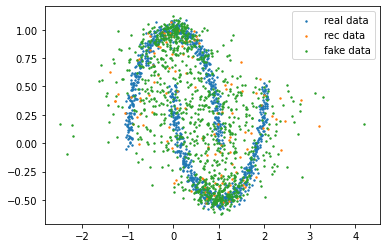

In [ ]:
elbo_loss = Train_VAE(N_ITER = 80000 , depth_enc = 3 , width_enc = 50 , depth_dec = 3 , width_dec = 50,  learn_sigma=True, fixed_sigma=None , verbose = True)

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

## Commentary :

Intuitevely having the decoder learn both the mean and the variance of the distribution should allow for better fitting of the distribution.

However our experiments have shown that (at least for the parameters we tested) that this results in distributions that fit less the training distribution.

We believe that adding the variance loss requires more tuning for the network in order to work but should result in better fitting.





KL: 3.640e+02, rec: -2.729e+02


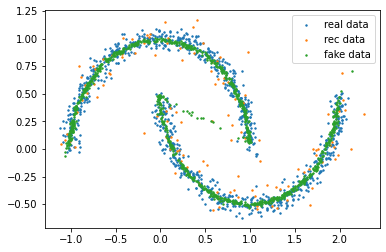

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 80001
# Batch size to use
BATCHLEN = 128


elbo_loss = Train_VAE(N_ITER  , depth_enc = 3 , width_enc = 50 , depth_dec = 3 , width_dec = 50,  learn_sigma=False, fixed_sigma= 1E-2, verbose = True)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**


KL: 2.013e+02, rec: -3.268e+01


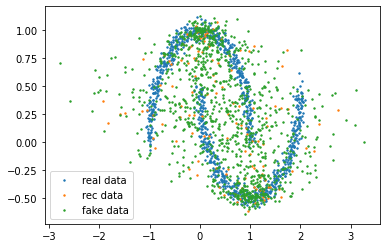


KL: 1.905e+02, rec: -8.728e+00


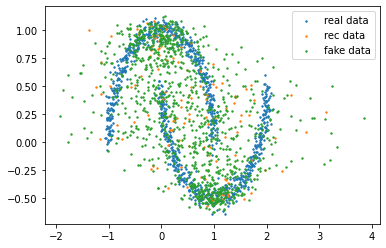


KL: 1.780e+02, rec: -5.352e+00


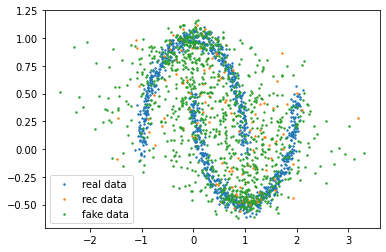


KL: 1.945e+02, rec: -3.594e+00


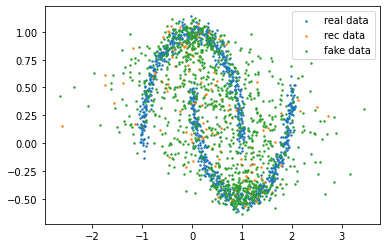


KL: 2.089e+02, rec: -1.842e+01


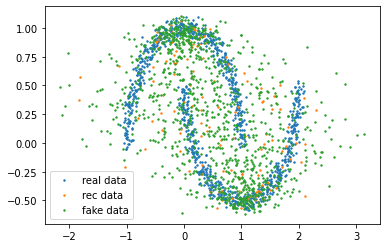


KL: 2.020e+02, rec: -2.290e+01


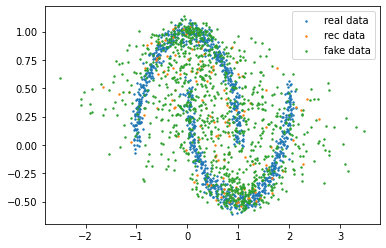


KL: 2.033e+02, rec: -3.658e+00


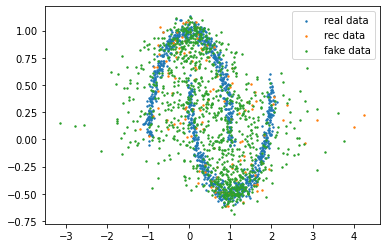


KL: 1.924e+02, rec: 7.290e+00


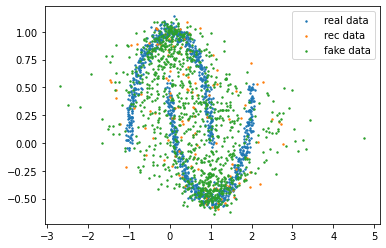


KL: 1.957e-04, rec: 2.537e+02


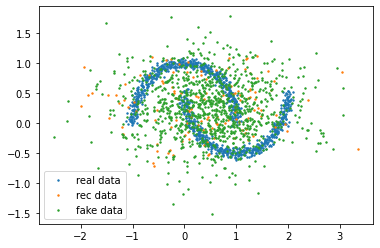


KL: 2.024e+02, rec: -1.635e+01


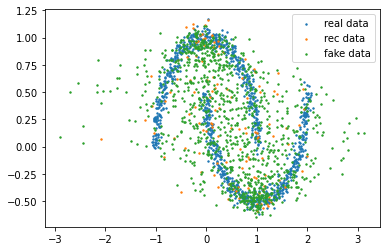


KL: 1.972e+02, rec: -1.563e+01


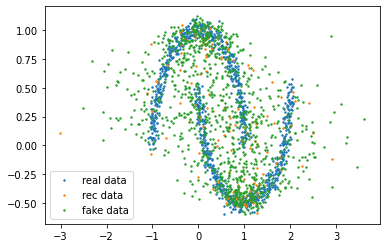


KL: 1.926e+02, rec: 6.424e+00


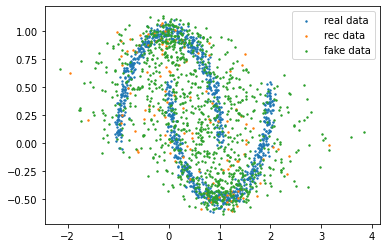

In [ ]:

depths = [3,5,20]
widths = [50,100,400]

N_ITER = 10000

depth_enc_loss = []
for d in depths:
    elbo_loss = Train_VAE(N_ITER  , depth_enc = d  , width_enc = 50 , depth_dec = 3 , width_dec = 50,  learn_sigma=True, fixed_sigma=None, verbose = True)
    depth_enc_loss.append((elbo_loss,d))

width_enc_loss = []
for w in widths:
    elbo_loss = Train_VAE(N_ITER  , depth_enc = 3  , width_enc = w , depth_dec = 3 , width_dec = 50,  learn_sigma=True, fixed_sigma=None, verbose = True)
    width_enc_loss.append((elbo_loss,w))


depth_dec_loss = []
for d in depths:
    elbo_loss = Train_VAE(N_ITER  , depth_enc = 3  , width_enc = 50 , depth_dec = d , width_dec = 50,  learn_sigma=True, fixed_sigma=None, verbose = True)
    depth_dec_loss.append((elbo_loss,d))

width_dec_loss = []
for w in widths:
    elbo_loss = Train_VAE(N_ITER  , depth_enc = 3  , width_enc = 50 , depth_dec = 3 , width_dec = w,  learn_sigma=True, fixed_sigma=None, verbose = True)
    width_dec_loss.append((elbo_loss,w))



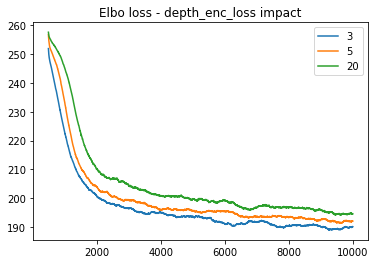

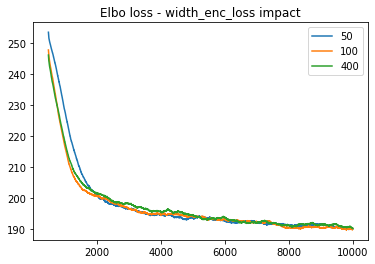

In [ ]:
#Comparing Elbo loss #
plt.plot(pd.Series(depth_enc_loss[0][0]).rolling(window=500).mean(),label=depth_enc_loss[0][1])
plt.plot(pd.Series(depth_enc_loss[1][0]).rolling(window=500).mean(),label=depth_enc_loss[1][1])
plt.plot(pd.Series(depth_enc_loss[2][0]).rolling(window=500).mean(),label=depth_enc_loss[2][1])
plt.legend()
plt.title('Elbo loss - depth_enc_loss impact')
plt.show()

#Comparing Elbo loss #
plt.plot(pd.Series(width_enc_loss[0][0]).rolling(window=500).mean(),label=width_enc_loss[0][1])
plt.plot(pd.Series(width_enc_loss[1][0]).rolling(window=500).mean(),label=width_enc_loss[1][1])
plt.plot(pd.Series(width_enc_loss[2][0]).rolling(window=500).mean(),label=width_enc_loss[2][1])
plt.legend()
plt.title('Elbo loss - width_enc_loss impact')
plt.show()


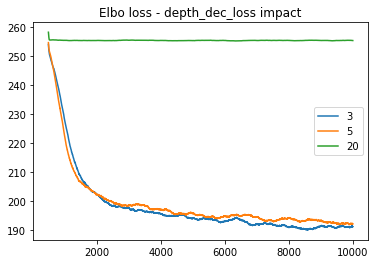

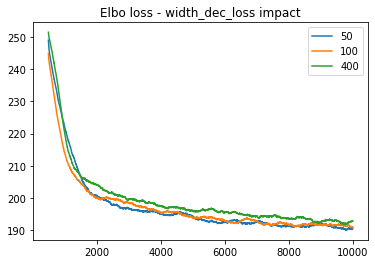

In [ ]:
#Comparing Elbo loss #
plt.plot(pd.Series(depth_dec_loss[0][0]).rolling(window=500).mean(),label=depth_dec_loss[0][1])
plt.plot(pd.Series(depth_dec_loss[1][0]).rolling(window=500).mean(),label=depth_dec_loss[1][1])
plt.plot(pd.Series(depth_dec_loss[2][0]).rolling(window=500).mean(),label=depth_dec_loss[2][1])
plt.legend()
plt.title('Elbo loss - depth_dec_loss impact')
plt.show()

#Comparing Elbo loss #
plt.plot(pd.Series(width_dec_loss[0][0]).rolling(window=500).mean(),label=width_dec_loss[0][1])
plt.plot(pd.Series(width_dec_loss[1][0]).rolling(window=500).mean(),label=width_dec_loss[1][1])
plt.plot(pd.Series(width_dec_loss[2][0]).rolling(window=500).mean(),label=width_dec_loss[2][1])
plt.legend()
plt.title('Elbo loss - width_dec_loss impact')
plt.show()


## Commentary :
> *Depths and widths of the encoder:* The higher the depths and widths of the encoder slower is the training, with large enough widths of the network (50 hiddens size) and small Depths of the encoder, the network converge to a small ELBO values and the training was fast, but it still depending on the problem to solve.

> *Depths and widths of the decode:* The higher the depths of the decoder the the training is not stable and the network does not converge, with large enough depths and widths of the network (3 layers ,50 hiddens size) the network converge to a small ELBO values.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

 we have :
$z = f(x)$

Then :
$ 
p_X(x)dx = p_Z(z)dz
$

$ 
p_X(x) = p_Z(z)\frac{dz}{dx}
$
$ 
 = p_Z(z)\frac{df(x)}{dx}
$
$ 
 = p_Z(z)det J_f
$
>Hence we have :
$\log(p_X(x))=\log(p_Z(z))+\log \det J_f$



Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> $\begin{align} D_{KL}(p_D \| p_G) &= E_{x \sim p_D} \left[ \log \frac{p_D(x)}{p_{G}(x)} \right] \\ &= E_{x \sim p_D} \left[ \log p_{D}(x) \right] - E_{x \sim p_D} \left[ \log p_{G}(x) \right] \\  &= Cte - E_{x \sim p_D} \left[ \log p_{G}(x) \right] \end{align}$


> since $E_{x \sim p_D} \left[ \log p_{D}(x) \right]$ is invariant.

> Hence, minimizing $D_{KL}(p_D \| p_G)$  is equivalent to minimizing $-\mathbb{E}_{p_D} \log p_G(x)$

> Given a  set of samples $\{x_n\}_{n=1}^N$ from $p_D(x)$:


 $L=\frac{1}{N}\sum_{n=1}^{N}(Cte -  \log p_{G}(x)  )$  

$=\frac{1}{N}\sum_{n=1}^{N}(Cte -  \log(p_Z(z))-\log \det J_f(x)  )$  
$=Cte -\frac{1}{N}\sum_{n=1}^{N}(  \log(p_Z(z))+\log \det J_f(x)  )$  

$argmin(L_f) = argmin(-\frac{1}{N}\sum_{n=1}^{N}(  \log(p_Z(z))+\log \det J_f(x)  )) $
>where :

$z$ ~ $\mathcal{N}(0,I)$


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

The inverse transformation can be written as :

* $x_{1:d} =y_{1:d}$
* $x_{d+1:D}=(y_{d+1:D}- t(x_{1:d})) \odot \frac{1}{exp(s(x_{1:d}))} $


**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

We have the function to learn is : 
$$
f_{RNVP}(x) = \left\{
    \begin{array}{ll}
        y_{1:d}=x_{1:d} \\
        y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})
    \end{array}
\right.
$$

hence, the jacobien is :

$$
J_{RNVP}(x) = \begin{pmatrix}
I_d & 0_{D-d}\\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}} & diag(exp(s(x_{1:d})))
\end{pmatrix} $$

the Jacobian is lower triangular:

then : $det(J_{RNVP}(x)) = \prod\limits_{j=1}^{D-d} exp(s(x_{1:d}))_j
= exp(\sum\limits_{j=1}^{D-d} (s(x_{1:d}))_j)
$





**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [1]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.relu(self.fc1(x_m))
        x_m = self.relu(self.fc2(x_m))
        x_m = self.tanh(self.fc3(x_m))
        
        return x_m
        
    def tfun(self, x_m):
        x_m = self.relu(self.fc1(x_m))
        x_m = self.relu(self.fc2(x_m))
        x_m = self.fc3(x_m)
        
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m) # multiplicative block
        t_out = self.tfun(y_m) # additive block
        y = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        
        return y

In [2]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all,  -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(3, 3, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [4]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [7]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32) # generate_data(1000).astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [8]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022166
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.031947
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.045420
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.047024
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.048487
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.049814
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.050008
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.050552
====> Epoch: 1 Average train loss: -0.0427


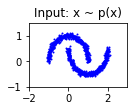

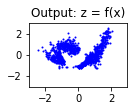

====> Test loss: -0.0528


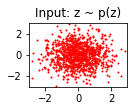

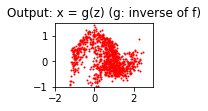

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.052169
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.052686
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.052888
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.052759
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.053221
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.054492
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.053636
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.054770
====> Epoch: 2 Average train loss: -0.0535


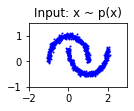

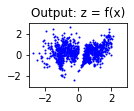

====> Test loss: -0.0565


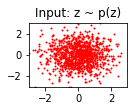

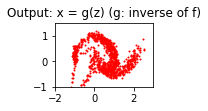

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.055141
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.053856
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.055819
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.055280
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.056052
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.056058
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.056141
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.056040
====> Epoch: 3 Average train loss: -0.0556


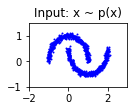

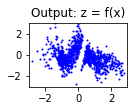

====> Test loss: -0.0567


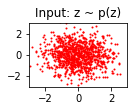

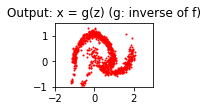

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.054797
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.056551
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.056664
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.057134
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.057427
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.057073
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.057193
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.056994
====> Epoch: 4 Average train loss: -0.0568


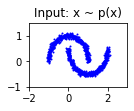

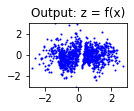

====> Test loss: -0.0585


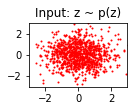

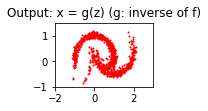

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.057484
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.056806
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.057474
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.056698
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.056058
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.056917
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.057830
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.056686
====> Epoch: 5 Average train loss: -0.0571


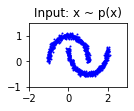

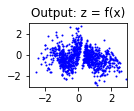

====> Test loss: -0.0578


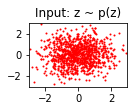

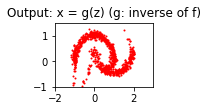

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.056616
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.058145
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.057227
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.057690
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.057397
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.057225
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.057837
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.057314
====> Epoch: 6 Average train loss: -0.0574


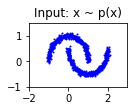

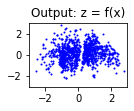

====> Test loss: -0.0588


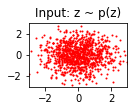

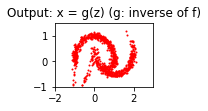

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.058144
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.055257
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.057553
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.056976
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.058555
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.057184
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.057924
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.057917
====> Epoch: 7 Average train loss: -0.0575


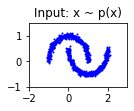

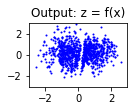

====> Test loss: -0.0590


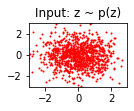

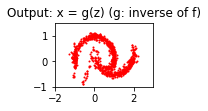

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.058289
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.057815
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.057909
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.056618
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.057698
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.058288
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.057397
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.056499
====> Epoch: 8 Average train loss: -0.0574


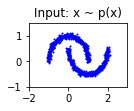

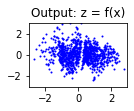

====> Test loss: -0.0590


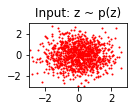

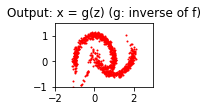

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.057740
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.058084
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.057272
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.056839
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.056535
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058467
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.058577
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.058257
====> Epoch: 9 Average train loss: -0.0576


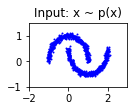

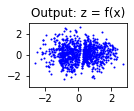

====> Test loss: -0.0593


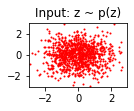

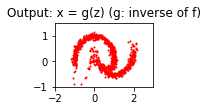

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.057775
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.057901
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.056602
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.058540
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.058039
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.057001
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.056557
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.057600
====> Epoch: 10 Average train loss: -0.0578


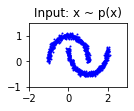

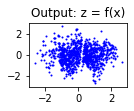

====> Test loss: -0.0592


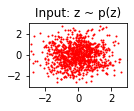

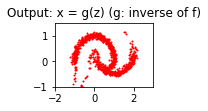

'93.82s'

<Figure size 432x288 with 0 Axes>

In [9]:

from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

def generate_data(n_samples = 150):
    n_samples_per_class = n_samples // 3
    x, c = make_moons(2*n_samples_per_class, noise=0.05, random_state=20)
    x1, c1 = x[c==0], c[c==0]
    x2, c2 = x[c==1], c[c==1]
    x, c = make_moons(2*n_samples_per_class, noise=0.05, random_state=10)
    x3, c3 = x[c==0], c[c==0]
    x = np.vstack([x1+(1,-0.2), x2+(1,-0.2), x3+(0,-1)] )
    c = np.hstack([c1, c2, c3+2] )
    x = x - x.mean(0)
    x = x / x.std(0)
    return x

def show_data(x, grid=None):
    colors = np.array([[ 0, 0.4, 1],[1,0,0.4],[0, 1, 0.5],[1, 0.7, 0.5]])
    plt.scatter(x[:,0], x[:,1], s=50, edgecolor='k', linewidth=1.5)
    if grid:
        from matplotlib.colors import ListedColormap
        xcoords, ycoords, zcoords = grid
        extent = (xcoords.min(), xcoords.max(), ycoords.min(), ycoords.max())
        C = len(np.unique(zcoords))
        cmap = ListedColormap(colors[:C])
        plt.imshow(zcoords, origin='lower', extent=extent, cmap=cmap, alpha=0.2, aspect='auto')
    plt.show()

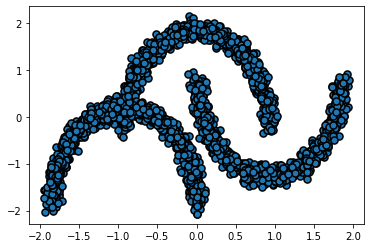

In [ ]:
x = generate_data(n_samples = 3000)
show_data(x, grid=None)
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 15
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 128
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 10
# data loading
train_data = generate_data(50000).astype(np.float32)
test_data = generate_data(1000).astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

Train Epoch: 1 [0/49998 (0%)]	Loss: 0.020859
Train Epoch: 1 [6400/49998 (13%)]	Loss: -0.012231
Train Epoch: 1 [12800/49998 (26%)]	Loss: -0.037465
Train Epoch: 1 [19200/49998 (38%)]	Loss: -0.048430
Train Epoch: 1 [25600/49998 (51%)]	Loss: -0.051463
Train Epoch: 1 [32000/49998 (64%)]	Loss: -0.054633
Train Epoch: 1 [38400/49998 (77%)]	Loss: -0.055952
Train Epoch: 1 [44800/49998 (90%)]	Loss: -0.056591
====> Epoch: 1 Average train loss: -0.0416


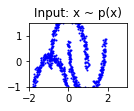

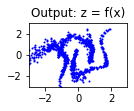

====> Test loss: -0.0586


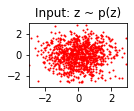

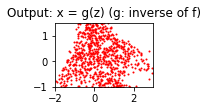

Train Epoch: 2 [0/49998 (0%)]	Loss: -0.057263
Train Epoch: 2 [6400/49998 (13%)]	Loss: -0.057467
Train Epoch: 2 [12800/49998 (26%)]	Loss: -0.059151
Train Epoch: 2 [19200/49998 (38%)]	Loss: -0.059022
Train Epoch: 2 [25600/49998 (51%)]	Loss: -0.058458
Train Epoch: 2 [32000/49998 (64%)]	Loss: -0.059968
Train Epoch: 2 [38400/49998 (77%)]	Loss: -0.059808
Train Epoch: 2 [44800/49998 (90%)]	Loss: -0.059828
====> Epoch: 2 Average train loss: -0.0590


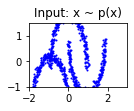

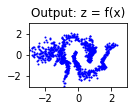

====> Test loss: -0.0615


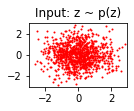

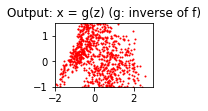

Train Epoch: 3 [0/49998 (0%)]	Loss: -0.059728
Train Epoch: 3 [6400/49998 (13%)]	Loss: -0.059920
Train Epoch: 3 [12800/49998 (26%)]	Loss: -0.060339
Train Epoch: 3 [19200/49998 (38%)]	Loss: -0.060191
Train Epoch: 3 [25600/49998 (51%)]	Loss: -0.060972
Train Epoch: 3 [32000/49998 (64%)]	Loss: -0.060734
Train Epoch: 3 [38400/49998 (77%)]	Loss: -0.060790
Train Epoch: 3 [44800/49998 (90%)]	Loss: -0.061228
====> Epoch: 3 Average train loss: -0.0606


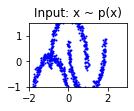

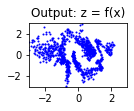

====> Test loss: -0.0626


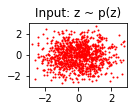

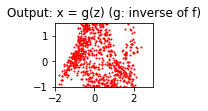

Train Epoch: 4 [0/49998 (0%)]	Loss: -0.061331
Train Epoch: 4 [6400/49998 (13%)]	Loss: -0.060599
Train Epoch: 4 [12800/49998 (26%)]	Loss: -0.061226
Train Epoch: 4 [19200/49998 (38%)]	Loss: -0.061258
Train Epoch: 4 [25600/49998 (51%)]	Loss: -0.061221
Train Epoch: 4 [32000/49998 (64%)]	Loss: -0.061357
Train Epoch: 4 [38400/49998 (77%)]	Loss: -0.062164
Train Epoch: 4 [44800/49998 (90%)]	Loss: -0.061892
====> Epoch: 4 Average train loss: -0.0614


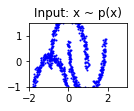

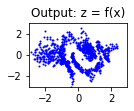

====> Test loss: -0.0634


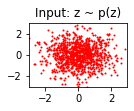

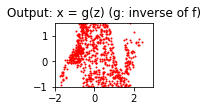

Train Epoch: 5 [0/49998 (0%)]	Loss: -0.061398
Train Epoch: 5 [6400/49998 (13%)]	Loss: -0.061461
Train Epoch: 5 [12800/49998 (26%)]	Loss: -0.061104
Train Epoch: 5 [19200/49998 (38%)]	Loss: -0.062491
Train Epoch: 5 [25600/49998 (51%)]	Loss: -0.062764
Train Epoch: 5 [32000/49998 (64%)]	Loss: -0.060779
Train Epoch: 5 [38400/49998 (77%)]	Loss: -0.062157
Train Epoch: 5 [44800/49998 (90%)]	Loss: -0.062635
====> Epoch: 5 Average train loss: -0.0620


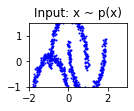

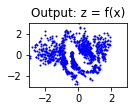

====> Test loss: -0.0642


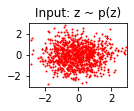

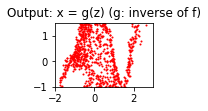

Train Epoch: 6 [0/49998 (0%)]	Loss: -0.062781
Train Epoch: 6 [6400/49998 (13%)]	Loss: -0.062176
Train Epoch: 6 [12800/49998 (26%)]	Loss: -0.062635
Train Epoch: 6 [19200/49998 (38%)]	Loss: -0.063287
Train Epoch: 6 [25600/49998 (51%)]	Loss: -0.062810
Train Epoch: 6 [32000/49998 (64%)]	Loss: -0.061835
Train Epoch: 6 [38400/49998 (77%)]	Loss: -0.062975
Train Epoch: 6 [44800/49998 (90%)]	Loss: -0.063439
====> Epoch: 6 Average train loss: -0.0627


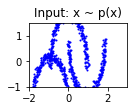

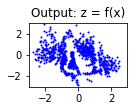

====> Test loss: -0.0640


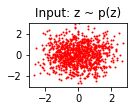

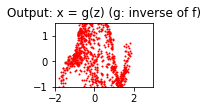

Train Epoch: 7 [0/49998 (0%)]	Loss: -0.062218
Train Epoch: 7 [6400/49998 (13%)]	Loss: -0.063211
Train Epoch: 7 [12800/49998 (26%)]	Loss: -0.061616
Train Epoch: 7 [19200/49998 (38%)]	Loss: -0.063243
Train Epoch: 7 [25600/49998 (51%)]	Loss: -0.062817
Train Epoch: 7 [32000/49998 (64%)]	Loss: -0.063258
Train Epoch: 7 [38400/49998 (77%)]	Loss: -0.063620
Train Epoch: 7 [44800/49998 (90%)]	Loss: -0.062907
====> Epoch: 7 Average train loss: -0.0631


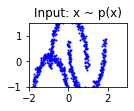

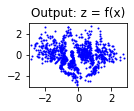

====> Test loss: -0.0651


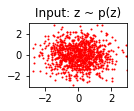

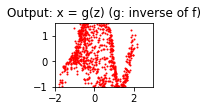

Train Epoch: 8 [0/49998 (0%)]	Loss: -0.062622
Train Epoch: 8 [6400/49998 (13%)]	Loss: -0.061604
Train Epoch: 8 [12800/49998 (26%)]	Loss: -0.063056
Train Epoch: 8 [19200/49998 (38%)]	Loss: -0.062789
Train Epoch: 8 [25600/49998 (51%)]	Loss: -0.063100
Train Epoch: 8 [32000/49998 (64%)]	Loss: -0.063031
Train Epoch: 8 [38400/49998 (77%)]	Loss: -0.063237
Train Epoch: 8 [44800/49998 (90%)]	Loss: -0.063124
====> Epoch: 8 Average train loss: -0.0634


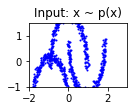

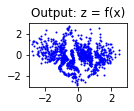

====> Test loss: -0.0652


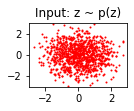

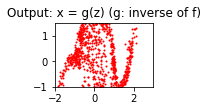

Train Epoch: 9 [0/49998 (0%)]	Loss: -0.063654
Train Epoch: 9 [6400/49998 (13%)]	Loss: -0.063986
Train Epoch: 9 [12800/49998 (26%)]	Loss: -0.063796
Train Epoch: 9 [19200/49998 (38%)]	Loss: -0.059542
Train Epoch: 9 [25600/49998 (51%)]	Loss: -0.061865
Train Epoch: 9 [32000/49998 (64%)]	Loss: -0.063623
Train Epoch: 9 [38400/49998 (77%)]	Loss: -0.063452
Train Epoch: 9 [44800/49998 (90%)]	Loss: -0.063833
====> Epoch: 9 Average train loss: -0.0629


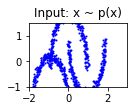

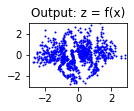

====> Test loss: -0.0654


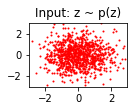

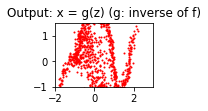

Train Epoch: 10 [0/49998 (0%)]	Loss: -0.064087
Train Epoch: 10 [6400/49998 (13%)]	Loss: -0.063633
Train Epoch: 10 [12800/49998 (26%)]	Loss: -0.063623
Train Epoch: 10 [19200/49998 (38%)]	Loss: -0.063882
Train Epoch: 10 [25600/49998 (51%)]	Loss: -0.063072
Train Epoch: 10 [32000/49998 (64%)]	Loss: -0.063882
Train Epoch: 10 [38400/49998 (77%)]	Loss: -0.064088
Train Epoch: 10 [44800/49998 (90%)]	Loss: -0.063810
====> Epoch: 10 Average train loss: -0.0638


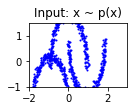

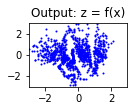

====> Test loss: -0.0654


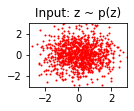

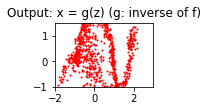

Train Epoch: 11 [0/49998 (0%)]	Loss: -0.064507
Train Epoch: 11 [6400/49998 (13%)]	Loss: -0.063451
Train Epoch: 11 [12800/49998 (26%)]	Loss: -0.062125
Train Epoch: 11 [19200/49998 (38%)]	Loss: -0.064305
Train Epoch: 11 [25600/49998 (51%)]	Loss: -0.063701
Train Epoch: 11 [32000/49998 (64%)]	Loss: -0.063616
Train Epoch: 11 [38400/49998 (77%)]	Loss: -0.063125
Train Epoch: 11 [44800/49998 (90%)]	Loss: -0.064319
====> Epoch: 11 Average train loss: -0.0638


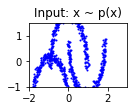

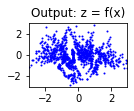

====> Test loss: -0.0655


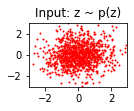

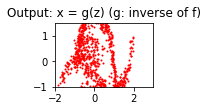

Train Epoch: 12 [0/49998 (0%)]	Loss: -0.063706
Train Epoch: 12 [6400/49998 (13%)]	Loss: -0.064532
Train Epoch: 12 [12800/49998 (26%)]	Loss: -0.064069
Train Epoch: 12 [19200/49998 (38%)]	Loss: -0.063831
Train Epoch: 12 [25600/49998 (51%)]	Loss: -0.063687
Train Epoch: 12 [32000/49998 (64%)]	Loss: -0.064060
Train Epoch: 12 [38400/49998 (77%)]	Loss: -0.064081
Train Epoch: 12 [44800/49998 (90%)]	Loss: -0.064393
====> Epoch: 12 Average train loss: -0.0639


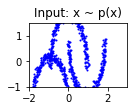

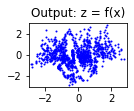

====> Test loss: -0.0655


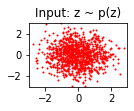

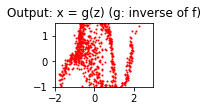

Train Epoch: 13 [0/49998 (0%)]	Loss: -0.063823
Train Epoch: 13 [6400/49998 (13%)]	Loss: -0.064202
Train Epoch: 13 [12800/49998 (26%)]	Loss: -0.064539
Train Epoch: 13 [19200/49998 (38%)]	Loss: -0.063746
Train Epoch: 13 [25600/49998 (51%)]	Loss: -0.063789
Train Epoch: 13 [32000/49998 (64%)]	Loss: -0.063580
Train Epoch: 13 [38400/49998 (77%)]	Loss: -0.064083
Train Epoch: 13 [44800/49998 (90%)]	Loss: -0.064051
====> Epoch: 13 Average train loss: -0.0638


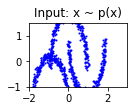

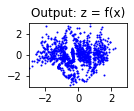

====> Test loss: -0.0657


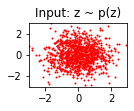

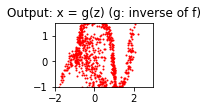

Train Epoch: 14 [0/49998 (0%)]	Loss: -0.063763
Train Epoch: 14 [6400/49998 (13%)]	Loss: -0.063781
Train Epoch: 14 [12800/49998 (26%)]	Loss: -0.063709
Train Epoch: 14 [19200/49998 (38%)]	Loss: -0.065270
Train Epoch: 14 [25600/49998 (51%)]	Loss: -0.063705
Train Epoch: 14 [32000/49998 (64%)]	Loss: -0.064482
Train Epoch: 14 [38400/49998 (77%)]	Loss: -0.064136
Train Epoch: 14 [44800/49998 (90%)]	Loss: -0.063858
====> Epoch: 14 Average train loss: -0.0642


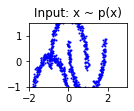

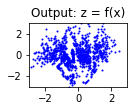

====> Test loss: -0.0656


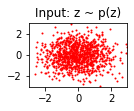

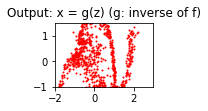

Train Epoch: 15 [0/49998 (0%)]	Loss: -0.064348
Train Epoch: 15 [6400/49998 (13%)]	Loss: -0.063957
Train Epoch: 15 [12800/49998 (26%)]	Loss: -0.063581
Train Epoch: 15 [19200/49998 (38%)]	Loss: -0.064344
Train Epoch: 15 [25600/49998 (51%)]	Loss: -0.064344
Train Epoch: 15 [32000/49998 (64%)]	Loss: -0.063056
Train Epoch: 15 [38400/49998 (77%)]	Loss: -0.063876
Train Epoch: 15 [44800/49998 (90%)]	Loss: -0.065247
====> Epoch: 15 Average train loss: -0.0642


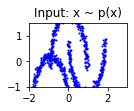

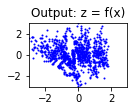

====> Test loss: -0.0656


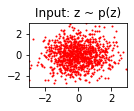

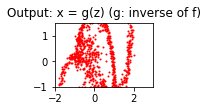

'135.61s'

<Figure size 432x288 with 0 Axes>

In [ ]:

from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> The main advantage of flow-based models is as described above, we can get an exact estimate of the likelihood of your sample, VAEs optimize a lower bound on the (log) likelihood and GANs minimize a discrepancy between your input and noise distributions. 
> GAN is explicitly set up to optimize for generative tasks and VAEs explicit goal is latent modeling.
An advantage for VAEs is that there is a way to evaluate the quality of the model (log-likelihood, either estimated by importance sampling or lower-bounded). it’s not clear how to evaluate a GAN or to compare a GAN and other generative models.
